In [ ]:
!pip install transformers
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install evaluate

In [ ]:
# import libraries
import json
import csv
import pandas as pd
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# the following code ensures that you can see your (print) results for multiple tasks within a coding block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
def convert_to_csv(json_file_path, csv_file_path):
    # Open the JSON file
    with open(json_file_path, "r") as f:
        data = json.load(f)

    # Open a CSV file for writing
    with open(csv_file_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)

        # Write the header row
        writer.writerow(["text", "hypothesis", "label"])

        # Loop over the documents in the JSON file
        for doc in data["documents"]:
            # Extract the document text
            text = doc["text"]

            # Loop over the hypotheses in the labels dictionary
            for key, value in data["labels"].items():
                # Extract the hypothesis text and label for the current key
                hypothesis = value["hypothesis"]
                label = doc["annotation_sets"][0]["annotations"][key]["choice"]

                # Write the text, hypothesis, and label to the CSV file
                writer.writerow([text, hypothesis, label])

In [ ]:
#convert train data to csv
csv_file_path = "/content/train.csv"
json_file_path = "/content/train.json"

train_df = convert_to_csv(json_file_path, csv_file_path)

train_df = pd.read_csv("/content/train.csv")
train_df.head()
train_df.shape

,text,hypothesis,label
0,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,NotMentioned
1,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall destroy or return some C...,Entailment
2,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Agreement shall not grant Receiving Party any ...,Entailment
3,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not disclose the fact th...,Entailment
4,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Confidential Information shall only include te...,NotMentioned


(7191, 3)

In [ ]:
#convert dev data to csv
csv_file_path = "/content/dev.csv"
json_file_path = "/content/dev.json"

validation_df = convert_to_csv(json_file_path, csv_file_path)

validation_df = pd.read_csv("/content/dev.csv")
validation_df.head()
validation_df.shape

,text,hypothesis,label
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment
1,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall destroy or return some C...,Entailment
2,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Agreement shall not grant Receiving Party any ...,Entailment
3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not disclose the fact th...,Entailment
4,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Confidential Information shall only include te...,Contradiction


(1037, 3)

In [ ]:
#convert test data to csv
csv_file_path = "/content/test.csv"
json_file_path = "/content/test.json"

testing_df = convert_to_csv(json_file_path, csv_file_path)

testing_df = pd.read_csv("/content/test.csv")
testing_df.head()
testing_df.shape

,text,hypothesis,label
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction


(2091, 3)

# Q_1: perform some statistics on the train, test, dev data

**note**

the CSV files were generated by looping across the keys and sub-keys in JSON files to generate the CSV files with specific columns (text,hypothesis,label)

In [ ]:
# define a function to calculate number of words for text column
def count_words(text):
    return len(str(text).split())

,text,hypothesis,label,word_counts_text
0,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,NotMentioned,1316
1,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall destroy or return some C...,Entailment,1316
2,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Agreement shall not grant Receiving Party any ...,Entailment,1316
3,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not disclose the fact th...,Entailment,1316
4,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Confidential Information shall only include te...,NotMentioned,1316


,text,hypothesis,label,word_counts_text
count,7191,7191,7191,7191.000000
unique,423,17,3,NaN
top,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,Entailment,NaN
freq,17,423,3530,NaN
mean,NaN,NaN,NaN,1673.631206
std,NaN,NaN,NaN,1029.016036
min,NaN,NaN,NaN,211.000000
25%,NaN,NaN,NaN,940.000000
50%,NaN,NaN,NaN,1504.000000
75%,NaN,NaN,NaN,2063.000000


(array([2176., 2805., 1190.,  561.,  306.,   85.,   34.,   17.,    0.,
          17.]),
 array([ 211. , 1032.7, 1854.4, 2676.1, 3497.8, 4319.5, 5141.2, 5962.9,
        6784.6, 7606.3, 8428. ]),
 <BarContainer object of 10 artists>)

(array([2820.,    0.,    0.,    0.,    0., 3530.,    0.,    0.,    0.,
         841.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

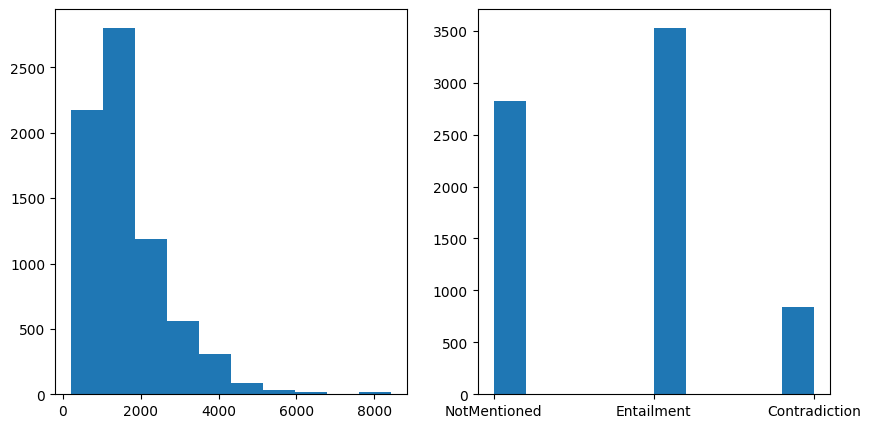

In [ ]:
# calculate the words in each record in text column
train_df["word_counts_text"] = train_df["text"].apply(count_words)
# print the first five raws in the train data ofter adding word_counts
train_df.head()
# print some statistics for the train data
train_df.describe(include = 'all')
# plot the distribution for the words count and label
fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10, 5))
plot1.hist(train_df["word_counts_text"])
plot2.hist(train_df["label"])

,text,hypothesis,label,word_counts_text
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment,1704
1,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall destroy or return some C...,Entailment,1704
2,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Agreement shall not grant Receiving Party any ...,Entailment,1704
3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not disclose the fact th...,Entailment,1704
4,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Confidential Information shall only include te...,Contradiction,1704


,text,hypothesis,label,word_counts_text
count,1037,1037,1037,1037.000000
unique,61,17,3,NaN
top,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment,NaN
freq,17,61,519,NaN
mean,NaN,NaN,NaN,1823.836066
std,NaN,NaN,NaN,1004.583793
min,NaN,NaN,NaN,342.000000
25%,NaN,NaN,NaN,1055.000000
50%,NaN,NaN,NaN,1727.000000
75%,NaN,NaN,NaN,2281.000000


(array([ 85., 340.,  68., 255., 119.,  34.,  34.,  51.,  17.,  34.]),
 array([ 342. ,  787.4, 1232.8, 1678.2, 2123.6, 2569. , 3014.4, 3459.8,
        3905.2, 4350.6, 4796. ]),
 <BarContainer object of 10 artists>)

(array([519.,   0.,   0.,   0.,   0.,  95.,   0.,   0.,   0., 423.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

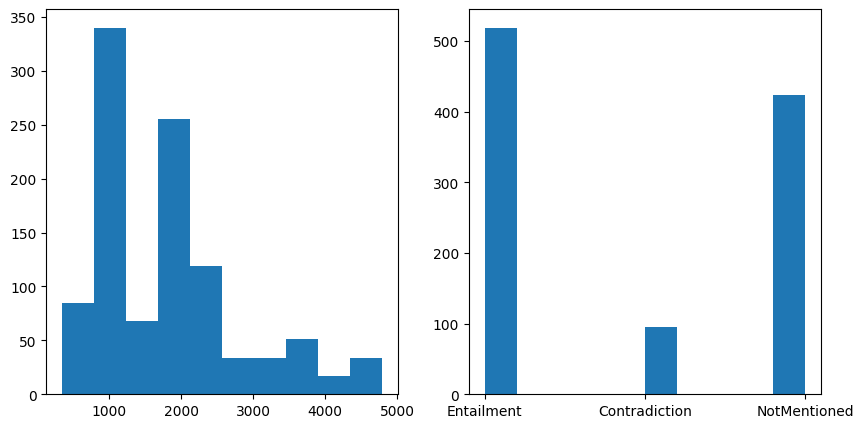

In [ ]:
# calculate the words in each record in text column
validation_df["word_counts_text"] = validation_df["text"].apply(count_words)
# print the first five raws in the dev data ofter adding word_counts
validation_df.head()
# print some statistics for the dev data
validation_df.describe(include = 'all')
# plot the distribution for the words count and label
fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10, 5))
plot1.hist(validation_df["word_counts_text"])
plot2.hist(validation_df["label"])

,text,hypothesis,label,word_counts_text
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,2454
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,2454
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,2454
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,2454
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,2454


,text,hypothesis,label,word_counts_text
count,2091,2091,2091,2091.000000
unique,122,17,3,NaN
top,DEPARTMENT OF HOMELAND SECURITY\nNON-DISCLOSUR...,Receiving Party shall not reverse engineer any...,Entailment,NaN
freq,34,123,968,NaN
mean,NaN,NaN,NaN,1708.821138
std,NaN,NaN,NaN,1111.083966
min,NaN,NaN,NaN,205.000000
25%,NaN,NaN,NaN,924.000000
50%,NaN,NaN,NaN,1417.000000
75%,NaN,NaN,NaN,2214.000000


(array([374., 680., 459., 255., 102., 136.,  34.,   0.,  17.,  34.]),
 array([ 205. ,  811.2, 1417.4, 2023.6, 2629.8, 3236. , 3842.2, 4448.4,
        5054.6, 5660.8, 6267. ]),
 <BarContainer object of 10 artists>)

(array([903.,   0.,   0.,   0.,   0., 968.,   0.,   0.,   0., 220.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

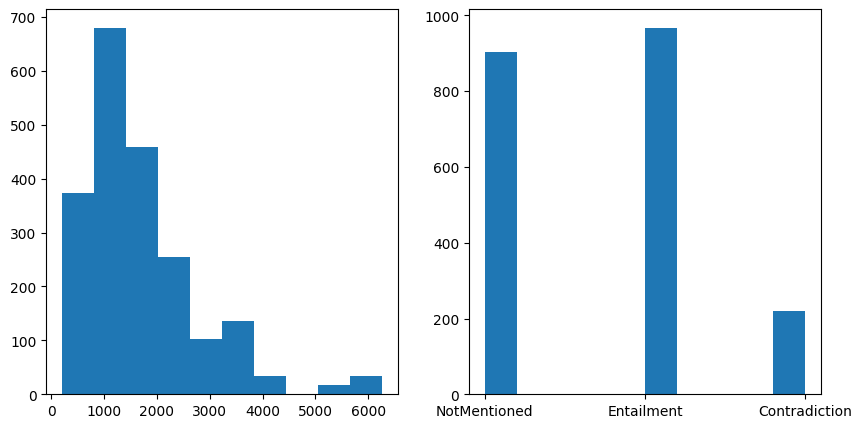

In [ ]:
# calculate the words in each record in text column
testing_df["word_counts_text"] = testing_df["text"].apply(count_words)
# print the first five raws in the test data ofter adding word_counts
testing_df.head()
# print some statistics for the dev data
testing_df.describe(include = 'all')
# plot the distribution for the words count and label
fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10, 5))
plot1.hist(testing_df["word_counts_text"])
plot2.hist(testing_df["label"])

# Q_2 part_1

# model_1 and reporting its performance

In [ ]:
# upload deberta model and tokenizer
model_name_1 = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name_1)

In [ ]:
# tokenization function to tokenize text and hypothesis column
def tokenize_data(data):
    return tokenizer(text=data['text'].tolist(), text_pair=data['hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)

In [ ]:
# customized data loader
class Data_Loader(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        # Here we ensure the label is an integer tensor
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# encode the label for each data
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

train_labels = [label_mapping[label] for label in train_df['label'].tolist()]
valid_labels = [label_mapping[label] for label in validation_df['label'].tolist()]
test_labels = [label_mapping[label] for label in testing_df['label'].tolist()]

# tokenize hypothesis column and text column
train_encodings = tokenize_data(train_df)
valid_encodings = tokenize_data(validation_df)
test_encodings = tokenize_data(testing_df)

In [ ]:
# perform data loader on each data set
train_dataset = Data_Loader(train_encodings, train_labels)
valid_dataset = Data_Loader(valid_encodings, valid_labels)
testing_dataset = Data_Loader(test_encodings, test_labels)

In [ ]:
# define the model
model_1 = AutoModelForSequenceClassification.from_pretrained(model_name_1, num_labels=3)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# sets up a configuration for training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

In [ ]:
# function to compute the metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    accuracy = (preds == p.label_ids).mean()
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model_1,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.706900,0.782793,0.592093,0.603974,0.592093,0.593813
2,0.640900,0.688129,0.696239,0.704263,0.696239,0.696709
3,0.563100,0.648241,0.719383,0.730588,0.719383,0.723298


TrainOutput(global_step=2697, training_loss=0.6936604558515425, metrics={'train_runtime': 3601.3956, 'train_samples_per_second': 5.99, 'train_steps_per_second': 0.749, 'total_flos': 6614280971596800.0, 'train_loss': 0.6936604558515425, 'epoch': 3.0})

**notes**

In the first epoch, the training loss is 0.7069 and the validation loss is 0.7828. The accuracy is 0.5921, the precision is 0.6040, the recall is 0.5921, and the F1 score is 0.5938.

In the second epoch, the training loss is 0.6409 and the validation loss is 0.6881. The accuracy is 0.6962, the precision is 0.7043, the recall is 0.6962, and the F1 score is 0.6967.

In the third epoch, the training loss is 0.5631 and the validation loss is 0.6482. The accuracy is 0.7194, the precision is 0.7306, the recall is 0.7194, and the F1 score is 0.7233.

it is obvious that the model seems to be improving over the epochs, with the highest accuracy, precision, recall, and F1 score achieved in the last epoch.

In [ ]:
# perform prediction on the test data
pred_1 = trainer.predict(testing_dataset)
print(pred_1.predictions.shape, pred_1.label_ids.shape)

(2091, 3) (2091,)


In [ ]:
# calculate the metrics
preds_1 = np.argmax(pred_1.predictions, axis=-1)

precision, recall, f1, _ = precision_recall_fscore_support(y_true=pred_1.label_ids, y_pred=preds_1, average='weighted')
accuracy = evaluate.load("accuracy").compute(predictions=preds_1, references=pred_1.label_ids)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: {'accuracy': 0.7288378766140603}
Precision: 0.734718039472865
Recall: 0.7288378766140603
F1 score: 0.7308012828785021


**note**

these results generated from test data indicates that the model is performing reasonably well on the testing data, with a good balance between precision and recall.

# Q3_ part_1
#error analysis for the first model (deberta)

In [ ]:
# add a new column in the test data contains number of words in the hypothesis column
testing_df["word_counts_hypothesis"] = testing_df["hypothesis"].apply(count_words)
# decode the predicted labels
mapping = {
    0: 'NotMentioned',
    1: 'Entailment',
    2: 'Contradiction'
}
# add a new column in the test data contains predicted labels
testing_df['pred_label_moedl_1'] = pd.DataFrame(preds_1).replace(mapping)
testing_df.head()

,text,hypothesis,label,word_counts_text,word_counts_hypothesis,pred_label_moedl_1
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,2454,14,NotMentioned
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,2454,14,NotMentioned
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,2454,11,Entailment
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,2454,13,NotMentioned
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,2454,7,Contradiction


In [ ]:
# compare between actual labels and predicted labels if the are not equal store them in a data frame called error_model_1
error_model_1 = testing_df[testing_df['label'] != testing_df['pred_label_moedl_1']]
# print the first five rows from error_model_1
error_model_1.head()
# print the dimensions of error_model_1
error_model_1.shape

,text,hypothesis,label,word_counts_text,word_counts_hypothesis,pred_label_moedl_1
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,2454,14,NotMentioned
5,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,All Confidential Information shall be expressl...,Contradiction,2454,11,NotMentioned
7,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may independently develop info...,Entailment,2454,10,NotMentioned
8,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may retain some Confidential I...,Entailment,2454,16,NotMentioned
11,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may share some Confidential In...,Entailment,2454,16,Contradiction


(567, 6)

(array([111., 212., 118.,  71.,  19.,  23.,   5.,   0.,   1.,   7.]),
 array([ 205. ,  811.2, 1417.4, 2023.6, 2629.8, 3236. , 3842.2, 4448.4,
        5054.6, 5660.8, 6267. ]),
 <BarContainer object of 10 artists>)

(array([ 57.,  86.,  78., 126.,  52., 117.,  19.,   0.,   0.,  32.]),
 array([ 7. ,  8.6, 10.2, 11.8, 13.4, 15. , 16.6, 18.2, 19.8, 21.4, 23. ]),
 <BarContainer object of 10 artists>)

(array([215.,   0.,   0.,   0.,   0.,  83.,   0.,   0.,   0., 269.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

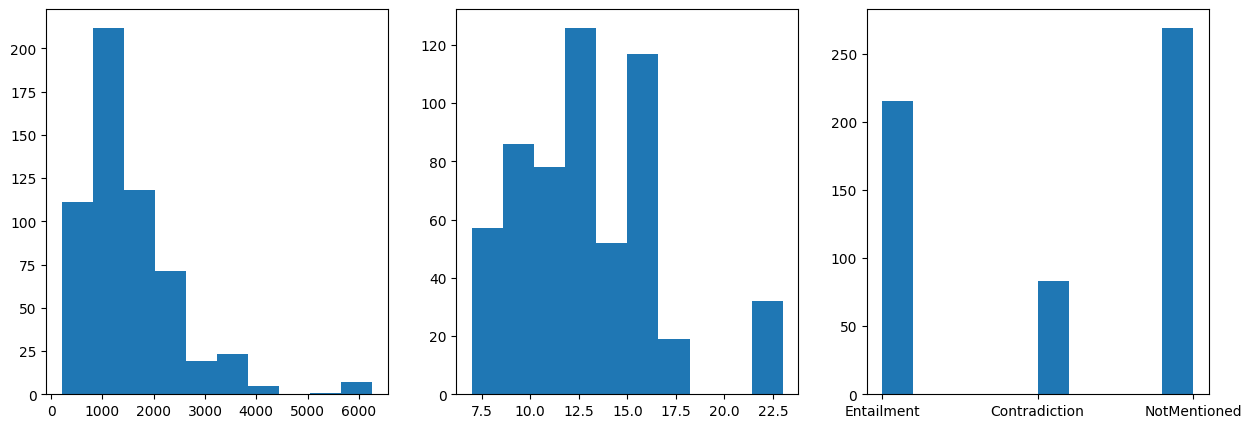

In [ ]:
# plot the frequency of the words count for text and hypothesis and label to gain some insights for error analysis
fig, (plot1, plot2, plot3) = plt.subplots(1, 3, figsize=(15, 5))
plot1.hist(error_model_1["word_counts_text"])
plot2.hist(error_model_1["word_counts_hypothesis"])
plot3.hist(error_model_1["label"])

**notes**

according to the above results it is obvious that the number of records the deberta model failed to classify ara 567 records

it seems that notmentioned label was highest as miss classified followed by entailment

regrding the number of words for the hypothesis the model had the highest miss classification with hypothesis with number of words from 11 to 17 words

in addition, text with about 1000 words has the highest miss classified ratio

# Q_2 part_2

# model_2 and reporting its performance

In [ ]:
# upload roberta model and tokenizer
model_name_2 = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name_2)

In [ ]:
# define the model
model_2 = AutoModelForSequenceClassification.from_pretrained(model_name_2, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# sets up a configuration for training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

In [ ]:
# function to compute the metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    accuracy = (preds == p.label_ids).mean()
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model_2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.706500,0.704333,0.688525,0.698112,0.688525,0.691953
2,0.702700,0.691463,0.707811,0.707369,0.707811,0.702922
3,0.624100,0.667989,0.702025,0.705288,0.702025,0.703046


TrainOutput(global_step=2697, training_loss=0.7299927121672667, metrics={'train_runtime': 2291.2264, 'train_samples_per_second': 9.415, 'train_steps_per_second': 1.177, 'total_flos': 5676145760646144.0, 'train_loss': 0.7299927121672667, 'epoch': 3.0})

**note**

In the first epoch, the training loss is 0.7065 and the validation loss is 0.7043. The accuracy is 0.6885, the precision is 0.6981, the recall is 0.6885, and the F1 score is 0.6920.

In the second epoch, the training loss is 0.7027 and the validation loss is 0.6915. The accuracy is 0.7078, the precision is 0.7074, the recall is 0.7078, and the F1 score is 0.7029.

In the third epoch, the training loss is 0.6241 and the validation loss is 0.6680. The accuracy is 0.7020, the precision is 0.7053, the recall is 0.7020, and the F1 score is 0.7030.

it is obvious that the model seems to be improving over the epochs, with the highest accuracy, precision, recall, and F1 score achieved in the second epoch.

In [ ]:
# perform prediction on the train data
pred_2 = trainer.predict(testing_dataset)
print(pred_2.predictions.shape, pred_2.label_ids.shape)

(2091, 3) (2091,)


In [ ]:
# calculate the metrics
preds_2 = np.argmax(pred_2.predictions, axis=-1)

precision, recall, f1, _ = precision_recall_fscore_support(y_true=pred_2.label_ids, y_pred=preds_2, average='weighted')
accuracy = evaluate.load("accuracy").compute(predictions=preds_2, references=pred_2.label_ids)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: {'accuracy': 0.6920133907221425}
Precision: 0.6894073131640939
Recall: 0.6920133907221425
F1 score: 0.6899794696856606


**note**

these results generated from test data indicates that the model is performing reasonably well on the testing data, with a good balance between precision and recall.

# Q3_part_2
# error analysis for the second model (roberta)

In [ ]:
# add a new column in the test data contains number of words in the hypothesis column
testing_df["word_counts_hypothesis"] = testing_df["hypothesis"].apply(count_words)
# decode the predicted labels
mapping = {
    0: 'NotMentioned',
    1: 'Entailment',
    2: 'Contradiction'
}
# add a new column in the test data contains predicted labels
testing_df['pred_label_moedl_2'] = pd.DataFrame(preds_2).replace(mapping)
testing_df.head()

,text,hypothesis,label,word_counts_text,word_counts_hypothesis,pred_label_moedl_2
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,2454,14,NotMentioned
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,2454,14,NotMentioned
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,2454,11,Entailment
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,2454,13,NotMentioned
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,2454,7,Contradiction


In [ ]:
# compare between actual labels and predicted labels if the are not equal store them in a data frame called error_model_2
error_model_2 = testing_df[testing_df['label'] != testing_df['pred_label_moedl_2']]
# print the first five rows from error_model_2
error_model_2.head()
# print the dimensions of error_model_2
error_model_2.shape

,text,hypothesis,label,word_counts_text,word_counts_hypothesis,pred_label_moedl_2
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,2454,14,NotMentioned
5,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,All Confidential Information shall be expressl...,Contradiction,2454,11,NotMentioned
8,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may retain some Confidential I...,Entailment,2454,16,Contradiction
9,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information may include verbally ...,NotMentioned,2454,7,Entailment
12,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party may create a copy of some Conf...,Entailment,2454,13,NotMentioned


(644, 6)

(array([130., 238., 135.,  78.,  25.,  24.,   6.,   0.,   0.,   8.]),
 array([ 205. ,  811.2, 1417.4, 2023.6, 2629.8, 3236. , 3842.2, 4448.4,
        5054.6, 5660.8, 6267. ]),
 <BarContainer object of 10 artists>)

(array([ 81.,  91.,  96., 131.,  63., 123.,  21.,   0.,   0.,  38.]),
 array([ 7. ,  8.6, 10.2, 11.8, 13.4, 15. , 16.6, 18.2, 19.8, 21.4, 23. ]),
 <BarContainer object of 10 artists>)

(array([216.,   0.,   0.,   0.,   0., 116.,   0.,   0.,   0., 312.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

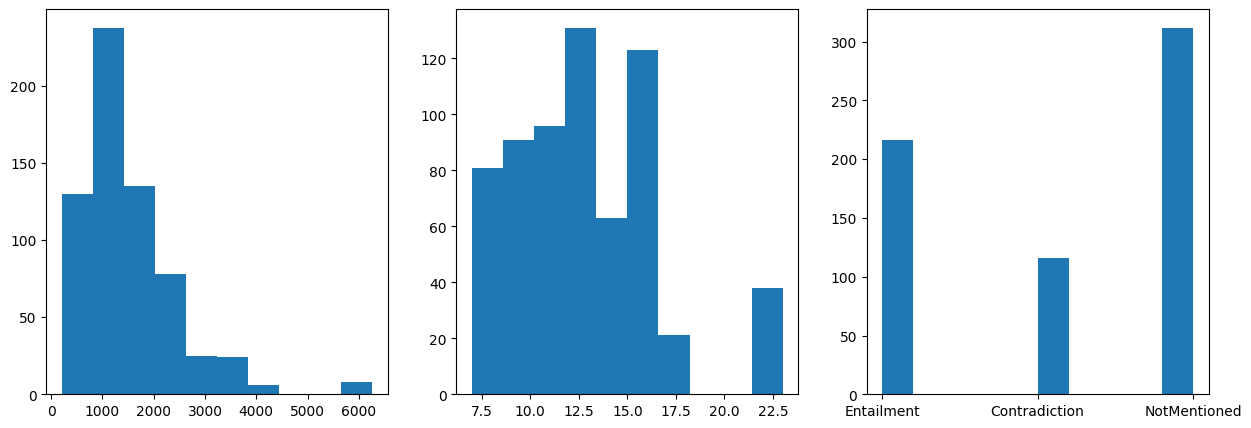

In [ ]:
# plot the frequency of the words count for text and hypothesis and label to gain some insights for error analysis
fig, (plot1, plot2, plot3) = plt.subplots(1, 3, figsize=(15, 5))
plot1.hist(error_model_2["word_counts_text"])
plot2.hist(error_model_2["word_counts_hypothesis"])
plot3.hist(error_model_2["label"])

**notes**

according to the above results it is obvious that the number of records the deberta model failed to classify ara 644 records

it seems that notmentioned label was highest as miss classified followed by entailment

regrding the number of words for the hypothesis the model had the highest miss classification with hypothesis with number of words from 7 to 17 words

in addition, text with about 1000 words has the highest miss classified ratio

# Q_2_part_3
# comparing between the two models

By comparing the results of the DeBERTa and RoBERTa models on the training and testing data, we can see that:

1- DeBERTa has higher accuracy, precision, recall, and F1 score on the testing data compared to RoBERTa.

2- Both models show improvement in performance on the training and validation data over the epochs.

3- DeBERTa achieves higher accuracy, precision, recall, and F1 score on the validation data in the last epoch compared to RoBERTa.

4- DeBERTa has higher initial training loss compared to RoBERTa, but achieves lower validation loss in the last epoch.

5- RoBERTa has higher initial validation loss compared to DeBERTa, but achieves lower validation loss in the last epoch.

the DeBERTa model seems to perform better than the RoBERTa model based on the evaluation metrics.

# Q_4

two ideas to improve the results of the DeBERTa and RoBERTa models:

1- Data Augmentation: a way to improve the performance of both models is to increase the amount of training data by using data augmentation techniques, specially for notmentioned and entailment classes because they have the higher miss classification ratio

2- Model Interpretability: a way to improve the interpretability of the DeBERTa and RoBERTa models is to use methods such as attention visualization, feature importance analysis, or saliency mapping to identify the most important features or tokens for the predictions. This can help identify potential biases or limitations of the models